In [1]:
import pandas as pd
import src
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "gene_families"
os.makedirs(figure_path, exist_ok=True)

## Define the subclusters of gene families

In [15]:
# gene_families = pd.read_csv(src.processed_data_path / "gene_families.tsv", sep='\t')
# gene_families.head()

In [16]:
# print("# Families:", gene_families.family.unique().shape[0])

### Associate to each gene its position in the genome

In [ ]:
# ensg_to_coord = pd.read_csv(src.external_data_path / "ensg_to_coord.txt", sep="\t")
# ensg_to_coord.columns = src.coords + ['strand', 'ensembl_gene_id', 'gene_type']
# ensg_to_coord['strand'] = ensg_to_coord.strand.map(lambda x: "+" if x == 1 else "-")
# ensg_to_coord['chr'] = 'chr' + ensg_to_coord.chr
# ensg_to_coord = ensg_to_coord.sort_values(src.coords).reset_index(drop=True)
# ensg_to_coord['gene_position'] = ensg_to_coord.index
# ensg_to_coord.head()

In [ ]:
# ensg_to_coord.shape

In [ ]:
# gene_families_with_position = gene_families.merge(ensg_to_coord[['ensembl_gene_id', 'gene_position']], on='ensembl_gene_id')
# gene_families_with_position = gene_families_with_position.sort_values('gene_position')
# gene_families_with_position.head()

In [17]:
gene_families_with_position = pd.read_csv(src.processed_data_path / "uniprot_families_human_with_coords.tsv", sep='\t')
gene_families_with_position = gene_families_with_position.rename(columns = {'family': 'family_name'})
family_names = sorted(gene_families_with_position.family_name.unique())
gene_families_with_position['family_id'] = gene_families_with_position.family_name.map(lambda x: family_names.index(x))
gene_families_with_position.head()

,chr,start,end,strand,gene_name,ensembl_gene_id,gene_position,gene_type,family_name,organism,uniprot_gene_id,uniprot_gene_name,uniprot_id,family_id
0,chr2,9613787,9636672,+,IAH1,ENSG00000134330,10713,protein_coding,'GDSL' lipolytic enzyme family. IAH1 subfamily,HUMAN,IAH1_HUMAN,IAH1,Q2TAA2,0
1,chr2,28680012,28866654,+,PLB1,ENSG00000163803,10850,protein_coding,'GDSL' lipolytic enzyme family. Phospholipase ...,HUMAN,PLB1_HUMAN,PLB1,Q6P1J6,1
2,chr11,117014983,117047610,+,PAFAH1B2,ENSG00000168092,3982,protein_coding,'GDSL' lipolytic enzyme family. Platelet-activ...,HUMAN,PA1B2_HUMAN,PAFAH1B2,P68402,2
3,chr19,42801185,42807698,-,PAFAH1B3,ENSG00000079462,10113,protein_coding,'GDSL' lipolytic enzyme family. Platelet-activ...,HUMAN,PA1B3_HUMAN,PAFAH1B3,Q15102,2
4,chr1,12704566,12727097,+,AADACL4,ENSG00000204518,171,protein_coding,'GDXG' lipolytic enzyme family,HUMAN,ADCL4_HUMAN,AADACL4,Q5VUY2,3


In [18]:
distance = 4

def adjacent_positions(l):
    cl = []
    current_cluster = [l[0]]
    for i in range(1, len(l)):
        if l[i] - current_cluster[-1] <= distance:
            current_cluster.append(l[i])
        else:
            cl.append(current_cluster)
            current_cluster = [l[i]]
    cl.append(current_cluster)
    return cl

In [19]:
sub_clusters = []

for family_id, family in src.progress(gene_families_with_position.groupby("family_id")):
    family = family.sort_values("gene_position")
    family_subclusters = adjacent_positions(family.gene_position.tolist())
    for i, sc in enumerate(family_subclusters):
        sub_clusters.append(family[family.gene_position.isin(sc)].assign(sub_cluster=i))
sub_clusters = pd.concat(sub_clusters, axis=0, ignore_index=True)
sub_clusters['cluster_uid'] = sub_clusters.family_id.astype(str) + "_" + sub_clusters.sub_cluster.astype(str)
sub_clusters.head()

,chr,start,end,strand,gene_name,ensembl_gene_id,gene_position,gene_type,family_name,organism,uniprot_gene_id,uniprot_gene_name,uniprot_id,family_id,sub_cluster,cluster_uid
0,chr2,9613787,9636672,+,IAH1,ENSG00000134330,10713,protein_coding,'GDSL' lipolytic enzyme family. IAH1 subfamily,HUMAN,IAH1_HUMAN,IAH1,Q2TAA2,0,0,0_0
1,chr2,28680012,28866654,+,PLB1,ENSG00000163803,10850,protein_coding,'GDSL' lipolytic enzyme family. Phospholipase ...,HUMAN,PLB1_HUMAN,PLB1,Q6P1J6,1,0,1_0
2,chr11,117014983,117047610,+,PAFAH1B2,ENSG00000168092,3982,protein_coding,'GDSL' lipolytic enzyme family. Platelet-activ...,HUMAN,PA1B2_HUMAN,PAFAH1B2,P68402,2,0,2_0
3,chr19,42801185,42807698,-,PAFAH1B3,ENSG00000079462,10113,protein_coding,'GDSL' lipolytic enzyme family. Platelet-activ...,HUMAN,PA1B3_HUMAN,PAFAH1B3,Q15102,2,1,2_1
4,chr1,12704566,12727097,+,AADACL4,ENSG00000204518,171,protein_coding,'GDXG' lipolytic enzyme family,HUMAN,ADCL4_HUMAN,AADACL4,Q5VUY2,3,0,3_0


In [20]:
sub_clusters.to_csv(src.interim_data_path / "gene_families_subclusters.tsv", sep="\t", index=False, header=True)

#### Some stats

In [19]:
max_subcluster_by_family = sub_clusters.groupby(['family_name', 'cluster_uid'])\
                                    .size()\
                                    .rename('n_genes')\
                                    .reset_index()\
                                    .groupby('family_name')['n_genes'].max().rename("max_subcluster")

family_stats = pd.concat((gene_families_with_position.groupby('family_name').size().rename("n_genes"), 
                          sub_clusters.groupby('family_name')['cluster_uid'].nunique().rename("n_sub_clusters"),
                          max_subcluster_by_family), axis=1)
family_stats.head()

,n_genes,n_sub_clusters,max_subcluster
family_name,,,
'GDSL' lipolytic enzyme family. IAH1 subfamily,1,1,1
'GDSL' lipolytic enzyme family. Phospholipase B1 subfamily,1,1,1
'GDSL' lipolytic enzyme family. Platelet-activating factor acetylhydrolase IB beta/gamma subunits subfamily,2,2,1
'GDXG' lipolytic enzyme family,6,4,2
1-acyl-sn-glycerol-3-phosphate acyltransferase family,12,12,1


In [30]:
top = family_stats.sort_values('max_subcluster', ascending=False).iloc[:50].reset_index().copy()
top.tail()

,family_name,n_genes,n_sub_clusters,max_subcluster
45,IFIT family,5,1,5
46,G-protein coupled receptor T2R family,24,11,5
47,GST superfamily. Mu family,5,1,5
48,GST superfamily. Alpha family,5,1,5
49,Abd-B homeobox family,15,6,5


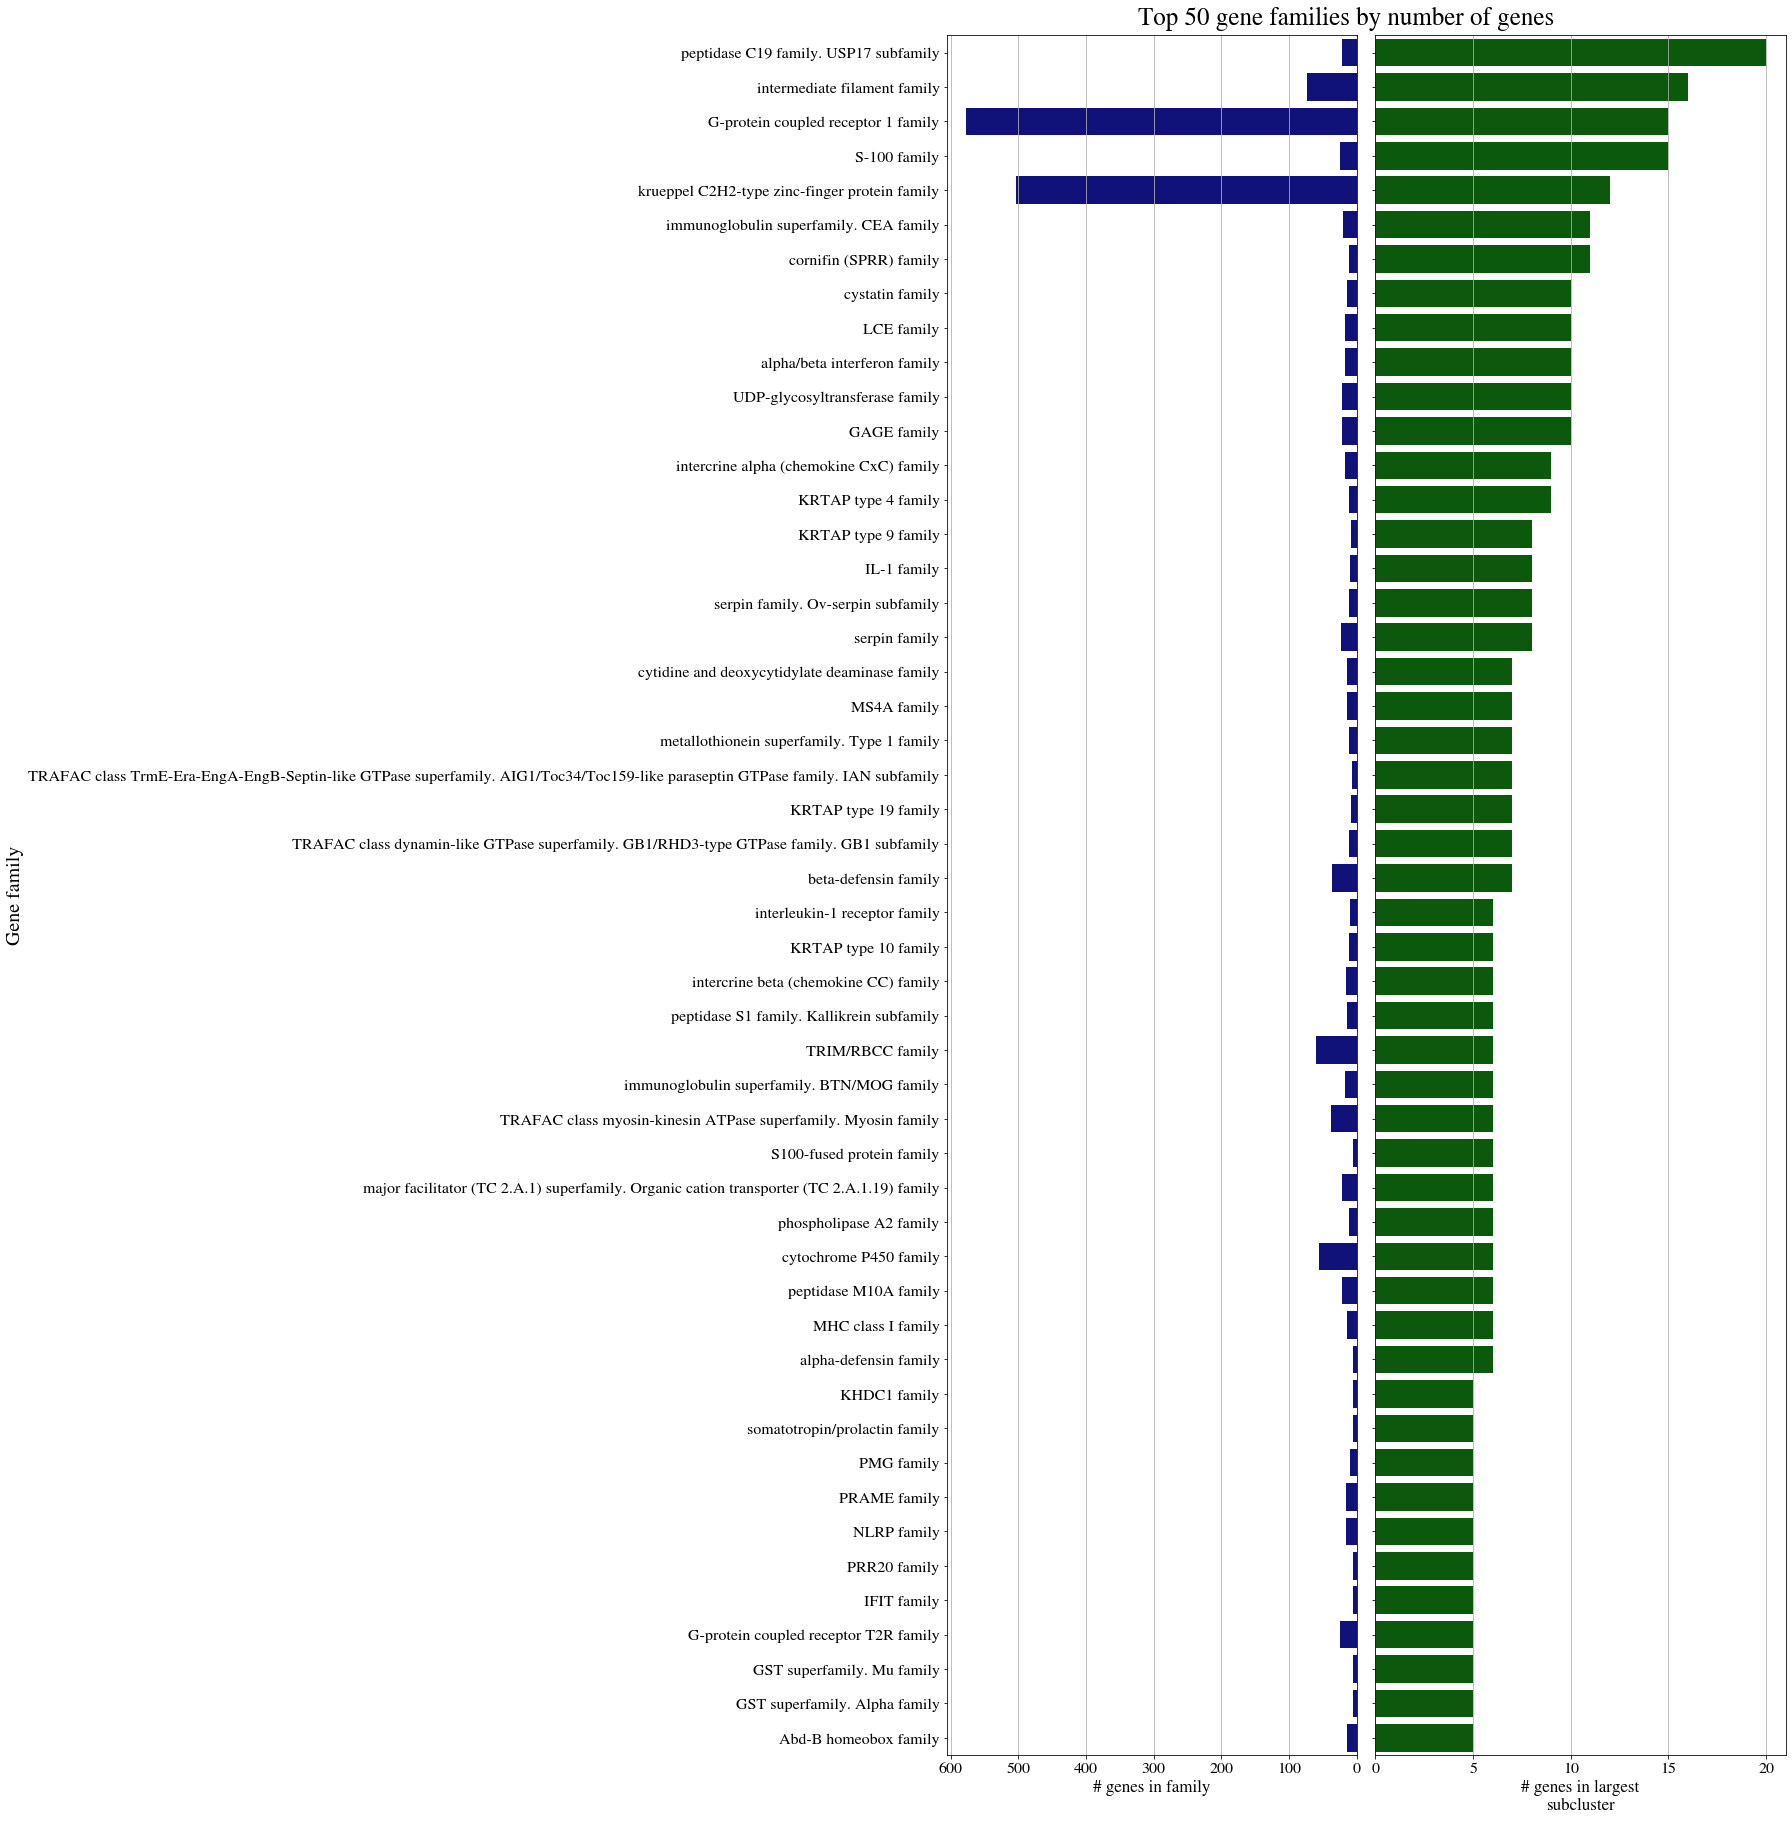

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(25, 25), sharey=True)
sns.barplot(data=top, x='n_genes', y='family_name', ax=axes[0], color='darkblue')
axes[0].set_xlabel("# genes in family")
axes[0].grid(axis='x')
sns.barplot(data=top, x='max_subcluster', y='family_name', ax=axes[1], color='darkgreen')
axes[1].set_xlabel("# genes in largest\nsubcluster")
axes[1].grid(axis='x')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[0].set_ylabel("Gene family", fontsize=20)
axes[1].set_ylabel("", fontsize=20)
fig.suptitle("Top 50 gene families by number of genes", x=0.75, y=1.01, ha='center', fontsize=25)
fig.savefig(figure_path / "top50_gene_families_n_genes_max_subcluster.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [25]:
sub_clusters = pd.read_csv(src.interim_data_path / "ggs.tsv", sep="\t")
sub_clusters['cluster_uid'] = sub_clusters.family_id.astype(str)+"_"+sub_clusters.sub_cluster.astype(str)
sub_clusters = sub_clusters.sort_values(src.coords).reset_index(drop=True)
sub_clusters.head()

,chr,start,end,strand,gene_name,ensembl_gene_id,gene_type,organism,class type,class,family_name,family_id,sub_cluster,cluster_uid
0,chr1,12834984,12838049,+,PRAMEF12,ENSG00000116726,protein_coding,HUMAN,1.0,bona-fide cluster - PRAME,PRAME,10001,0,10001_0
1,chr1,12851546,12856777,+,PRAMEF1,ENSG00000116721,protein_coding,HUMAN,1.0,bona-fide cluster - PRAME,PRAME,10001,0,10001_0
2,chr1,12884468,12891264,-,PRAMEF11,ENSG00000204513,protein_coding,HUMAN,1.0,bona-fide cluster - PRAME,PRAME,10001,0,10001_0
3,chr1,12907261,12908578,-,HNRNPCL1,ENSG00000179172,protein_coding,HUMAN,1.0,bona-fide cluster - PRAME,PRAME,10001,0,10001_0
4,chr1,12916941,12921764,+,PRAMEF2,ENSG00000120952,protein_coding,HUMAN,1.0,bona-fide cluster - PRAME,PRAME,10001,0,10001_0


### Create subclusters regions

In [23]:
sub_clusters_regions = sub_clusters.groupby(['family_id', 'family_name', 'sub_cluster', 'cluster_uid']).agg({
                                                        'chr': 'first', 
                                                        'start':'min', 
                                                        'end': 'max', 
                                                        'gene_name': [lambda x: ",".join(x), 'count'],
                                                        'ensembl_gene_id': lambda x: ",".join(x)})
sub_clusters_regions.columns = src.coords + ['genes', 'n_genes', 'ensembl_gene_id']
sub_clusters_regions = sub_clusters_regions.reset_index()
sub_clusters_regions['length'] = sub_clusters_regions.end - sub_clusters_regions.start
# sub_clusters_regions = sub_clusters_regions.merge(gene_families[['family_id', 'family_name']].drop_duplicates(), on='family_id')
sub_clusters_regions = sub_clusters_regions[src.coords + ['length', 'genes', 'ensembl_gene_id', 'n_genes', 'family_id', 'family_name', 'sub_cluster', 'cluster_uid']]
sub_clusters_regions.to_csv(src.interim_data_path / "gene_families_subcluster_regions_CURATED.tsv", sep="\t", index=False, header=True)
sub_clusters_regions.head()

,chr,start,end,length,genes,ensembl_gene_id,n_genes,family_id,family_name,sub_cluster,cluster_uid
0,chr10,90346510,90580303,233793,"LIPJ,LIPF,LIPK,LIPN,LIPM","ENSG00000204022,ENSG00000182333,ENSG0000020402...",5,46,AB hydrolase superfamily. Lipase family,0,46_0
1,chr17,66863433,67323385,459952,"ABCA8,ABCA9,ABCA6,ABCA10,ABCA5","ENSG00000141338,ENSG00000154258,ENSG0000015426...",5,49,ABC transporter superfamily. ABCA family,2,49_2
2,chr16,20420856,20808903,388047,"ACSM5,ACSM2A,ACSM2B,ACSM3,ACSM1","ENSG00000183549,ENSG00000183747,ENSG0000006681...",5,162,ATP-dependent AMP-binding enzyme family,7,162_7
3,chr12,54332535,54384063,51528,"HOXC13,HOXC12,HOXC11,HOXC10","ENSG00000123364,ENSG00000123407,ENSG0000012338...",4,188,Abd-B homeobox family,0,188_0
4,chr2,176957619,176989853,32234,"HOXD13,HOXD12,HOXD11,HOXD10,HOXD9","ENSG00000128714,ENSG00000170178,ENSG0000012871...",5,188,Abd-B homeobox family,2,188_2


In [24]:
sub_clusters_regions[sub_clusters_regions.length < 100000]

,chr,start,end,length,genes,ensembl_gene_id,n_genes,family_id,family_name,sub_cluster,cluster_uid
3,chr12,54332535,54384063,51528,"HOXC13,HOXC12,HOXC11,HOXC10","ENSG00000123364,ENSG00000123407,ENSG0000012338...",4,188,Abd-B homeobox family,0,188_0
4,chr2,176957619,176989853,32234,"HOXD13,HOXD12,HOXD11,HOXD10,HOXD9","ENSG00000128714,ENSG00000170178,ENSG0000012871...",5,188,Abd-B homeobox family,2,188_2
5,chr7,27202054,27239725,37671,"HOXA9,HOXA10,HOXA11,HOXA13","ENSG00000078399,ENSG00000253293,ENSG0000000507...",4,188,Abd-B homeobox family,3,188_3
6,chr17,46626232,46710934,84702,"HOXB3,HOXB5,HOXB6,HOXB7,HOXB8","ENSG00000120093,ENSG00000120075,ENSG0000010851...",5,193,Antp homeobox family,2,193_2
7,chr7,27145803,27197555,51752,"HOXA3,HOXA5,HOXA6,HOXA7","ENSG00000105997,ENSG00000106004,ENSG0000010600...",4,193,Antp homeobox family,5,193_5
10,chr14,74003818,74086592,82774,"ACOT1,ACOT2,ACOT4,ACOT6","ENSG00000184227,ENSG00000119673,ENSG0000017746...",4,266,C/M/P thioester hydrolase family,0,266_0
11,chr11,298200,327537,29337,"IFITM5,IFITM2,IFITM1,IFITM3","ENSG00000206013,ENSG00000185201,ENSG0000018588...",4,331,CD225/Dispanin family,0,331_0
14,chr19,35606732,35660786,54054,"FXYD3,FXYD1,FXYD7,FXYD5","ENSG00000089356,ENSG00000266964,ENSG0000022194...",4,911,FXYD family,2,911_2
35,chr6,132873832,132967142,93310,"TAAR8,TAAR6,TAAR5,TAAR2,TAAR1","ENSG00000146385,ENSG00000146383,ENSG0000013556...",5,919,G-protein coupled receptor 1 family,191,919_191
55,chr11,71238313,71314399,76086,"KRTAP5-7,KRTAP5-8,KRTAP5-10,KRTAP5-11","ENSG00000244411,ENSG00000241233,ENSG0000020457...",4,1244,KRTAP type 5 family,1,1244_1
